<a href="https://colab.research.google.com/github/dellacortelab/DeepLearningExamples/blob/master/Dietary_GI_GL_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's learn how to add Dietary GI variables to a subset of the NHANES national health survey dataset.

1. We will load the dataset.
2. We will assign GI values.
3. We calculate GL values.
4. We aggregate the data get dietary GL values.
5. We calculate dietary GI values.
6. We perform some basic reporting.

In [3]:
!git clone https://github.com/dellacortelab/nhanes_gigl.git

Cloning into 'nhanes_gigl'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 294.07 KiB | 3.06 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
import pickle
with open('./nhanes_gigl/demo_data.pkl', 'rb') as f:
  df = pickle.load(f)

Explore the Data Frame.

In [5]:
df

,respondent sequence number,Dietary 20 Year Weight,Data release cycle,USDA food code,Energy (kcal),Carbohydrate (gm),Dietary fiber (gm),Day
0,1.0,1213.225733,1,57348000.0,154.60,36.37,0.82,1.0
1,1.0,1213.225733,1,11112110.0,121.20,11.71,0.00,1.0
2,1.0,1213.225733,1,63149010.0,72.96,16.37,1.14,1.0
3,1.0,1213.225733,1,91611000.0,63.36,16.63,0.00,1.0
4,1.0,1213.225733,1,51101000.0,34.71,6.44,0.30,1.0
...,...,...,...,...,...,...,...,...
2259910,102951.0,9089.858831,10,58407030.0,205.00,28.04,1.30,2.0
2259911,102951.0,9089.858831,10,94100100.0,0.00,0.00,0.00,2.0
2259912,102951.0,9089.858831,10,27510241.0,490.00,30.72,1.10,2.0
2259913,102951.0,9089.858831,10,83110000.0,38.00,2.22,0.00,2.0


Let's extract the unique food codes.

In [6]:
food_codes = df['USDA food code'].unique().astype(int)
print('Example food code 1:', food_codes[0],'\nExmaple food code 2:', food_codes[1])


Example food code 1: 57348000 
Exmaple food code 2: 11112110


Now see if you can find the description of the food on: https://fdc.nal.usda.gov/

Now let's find the GI values associated with these food: https://glycemicindex.com/gi-search/

Imagine you would have to do this for over 10k food codes by hand! Enter the AI!

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine

# Initialize the BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Define the food descriptions
food1 = "Food Description from FoodData Central"
food2 = "Food Description from GI Database"

# Tokenize and encode the food descriptions
inputs1 = tokenizer(food1, return_tensors='pt', truncation=True, padding=True)
inputs2 = tokenizer(food2, return_tensors='pt', truncation=True, padding=True)

# Get the embeddings for the food descriptions
with torch.no_grad():
    embed1 = model(**inputs1).last_hidden_state.mean(dim=1)
    embed2 = model(**inputs2).last_hidden_state.mean(dim=1)

# Calculate the cosine similarity
similarity = 1 - cosine(embed1.numpy()[0,:], embed2.numpy()[0,:])

print(f"The cosine similarity between the food descriptions is {similarity}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The cosine similarity between the food descriptions is 0.8749364614486694


The code above could be used to compare thousands of food descriptions between different databases. It uses a somewhat aged AI, called BERT. Our paper uses a more modern Large Language Model from Open-AI (the makers of ChatGPT). But for our purposes this example suffices.

Let's assume that we used the AI to align all food codes with corresponding GI values. Here, we will take random numbers for sake of time.

In [8]:
import numpy as np
gi_values = [np.random.randint(45,100) for food_code in food_codes]
food_codes_to_gi = dict(zip(food_codes, gi_values))
for key in list(food_codes_to_gi.keys())[:5]:
  print(key,':', food_codes_to_gi[key])

57348000 : 76
11112110 : 87
63149010 : 48
91611000 : 45
51101000 : 92


Now, let's add the new GI variable to our dataframe!

In [9]:
df['GI'] = df['USDA food code'].map(food_codes_to_gi)
df

,respondent sequence number,Dietary 20 Year Weight,Data release cycle,USDA food code,Energy (kcal),Carbohydrate (gm),Dietary fiber (gm),Day,GI
0,1.0,1213.225733,1,57348000.0,154.60,36.37,0.82,1.0,76
1,1.0,1213.225733,1,11112110.0,121.20,11.71,0.00,1.0,87
2,1.0,1213.225733,1,63149010.0,72.96,16.37,1.14,1.0,48
3,1.0,1213.225733,1,91611000.0,63.36,16.63,0.00,1.0,45
4,1.0,1213.225733,1,51101000.0,34.71,6.44,0.30,1.0,92
...,...,...,...,...,...,...,...,...,...
2259910,102951.0,9089.858831,10,58407030.0,205.00,28.04,1.30,2.0,86
2259911,102951.0,9089.858831,10,94100100.0,0.00,0.00,0.00,2.0,59
2259912,102951.0,9089.858831,10,27510241.0,490.00,30.72,1.10,2.0,51
2259913,102951.0,9089.858831,10,83110000.0,38.00,2.22,0.00,2.0,91


Now let's calculate the GL value for each meal. This needs to take into account the available carbohydrates.

In [10]:
df['Available Carbohydrate'] = df['Carbohydrate (gm)'] - df['Dietary fiber (gm)']
df['GL'] = df['GI'] * df['Available Carbohydrate'] / 100
df

,respondent sequence number,Dietary 20 Year Weight,Data release cycle,USDA food code,Energy (kcal),Carbohydrate (gm),Dietary fiber (gm),Day,GI,Available Carbohydrate,GL
0,1.0,1213.225733,1,57348000.0,154.60,36.37,0.82,1.0,76,35.55,27.0180
1,1.0,1213.225733,1,11112110.0,121.20,11.71,0.00,1.0,87,11.71,10.1877
2,1.0,1213.225733,1,63149010.0,72.96,16.37,1.14,1.0,48,15.23,7.3104
3,1.0,1213.225733,1,91611000.0,63.36,16.63,0.00,1.0,45,16.63,7.4835
4,1.0,1213.225733,1,51101000.0,34.71,6.44,0.30,1.0,92,6.14,5.6488
...,...,...,...,...,...,...,...,...,...,...,...
2259910,102951.0,9089.858831,10,58407030.0,205.00,28.04,1.30,2.0,86,26.74,22.9964
2259911,102951.0,9089.858831,10,94100100.0,0.00,0.00,0.00,2.0,59,0.00,0.0000
2259912,102951.0,9089.858831,10,27510241.0,490.00,30.72,1.10,2.0,51,29.62,15.1062
2259913,102951.0,9089.858831,10,83110000.0,38.00,2.22,0.00,2.0,91,2.22,2.0202


Now we can sum up all the food items consumed by a given respondent in the NHANES survey. If we do this for each day of reporting, we will get Dietary GL.

In [11]:
agg_dict = {
    'Dietary 20 Year Weight': 'first',
    'Energy (kcal)': 'sum',
    'Data release cycle': 'first',
    'Available Carbohydrate':'sum',
    'GI': 'sum',
    'GL': 'sum'
}
summed_df = df.groupby(['respondent sequence number','Day']).agg(agg_dict).reset_index()
summed_df.rename(columns={'GL': 'Dietary GL'}, inplace=True)
summed_df['Dietary GI'] = summed_df['Dietary GL'] / summed_df['Available Carbohydrate']*100
summed_df


,respondent sequence number,Day,Dietary 20 Year Weight,Energy (kcal),Data release cycle,Available Carbohydrate,GI,Dietary GL,Dietary GI
0,1.0,1.0,1213.225733,1358.88,1,242.95,1124,189.5871,78.035439
1,73.0,1.0,1441.458533,1089.91,1,186.59,647,159.5265,85.495739
2,93.0,1.0,11027.861243,1376.98,1,149.60,1591,114.1850,76.326872
3,962.0,1.0,6592.491222,1622.83,1,244.07,969,185.1560,75.861843
4,1126.0,1.0,2010.452172,1467.16,1,153.51,1214,107.4951,70.024819
...,...,...,...,...,...,...,...,...,...
1789,102553.0,2.0,1020.750383,2730.00,10,252.69,1771,177.5160,70.250505
1790,102823.0,1.0,6265.820687,1468.00,10,190.04,1714,143.4377,75.477636
1791,102823.0,2.0,5478.640411,1045.00,10,120.45,1308,86.4443,71.767787
1792,102951.0,1.0,6832.369652,1471.00,10,196.79,1087,131.3206,66.731338


Finally, we need to average over the different days, for those who respondent more than once.

In [12]:
agg_dict = {
    'Dietary 20 Year Weight': 'mean',
    'Energy (kcal)': 'mean',
    'Available Carbohydrate':'mean',
    'Dietary GI': 'mean',
    'Dietary GL': 'mean',
    'Data release cycle': 'first',

}
summed_df = summed_df.groupby(['respondent sequence number']).agg(agg_dict).reset_index()
summed_df

,respondent sequence number,Dietary 20 Year Weight,Energy (kcal),Available Carbohydrate,Dietary GI,Dietary GL,Data release cycle
0,1.0,1213.225733,1358.88,242.950,78.035439,189.58710,1
1,73.0,1441.458533,1089.91,186.590,85.495739,159.52650,1
2,93.0,11027.861243,1376.98,149.600,76.326872,114.18500,1
3,962.0,6592.491222,1622.83,244.070,75.861843,185.15600,1
4,1126.0,2010.452172,1467.16,153.510,70.024819,107.49510,1
...,...,...,...,...,...,...,...
984,102352.0,2729.342226,2305.50,270.765,75.231085,202.66705,10
985,102435.0,515.042577,3042.00,397.865,77.884912,309.83780,10
986,102553.0,1074.611849,2470.00,256.925,70.009040,179.86050,10
987,102823.0,5872.230549,1256.50,155.245,73.622712,114.94100,10


Now we could do some exploration of the participants. In the example data, we only have Data release cycle as a variable. Others are available from NHANES and were used in the paper. Here, however, we just focus on time trends. Let's plot the average values and approximate the errors.

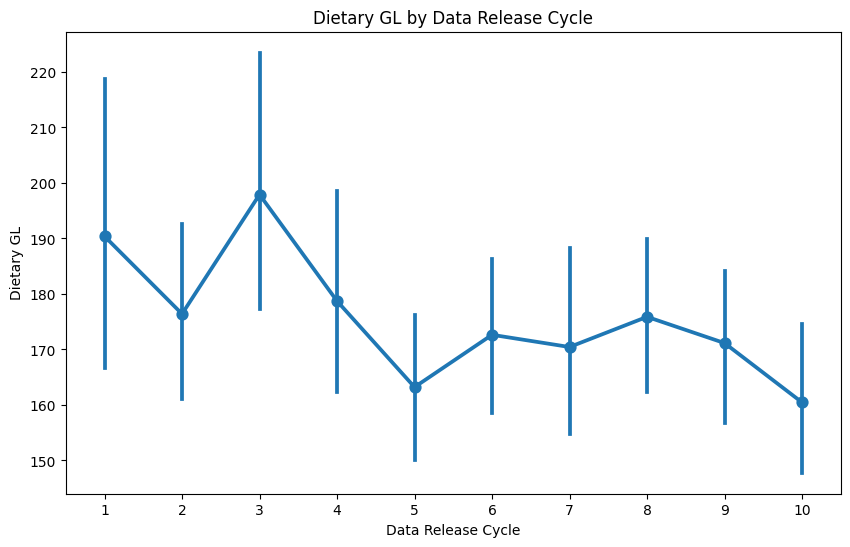

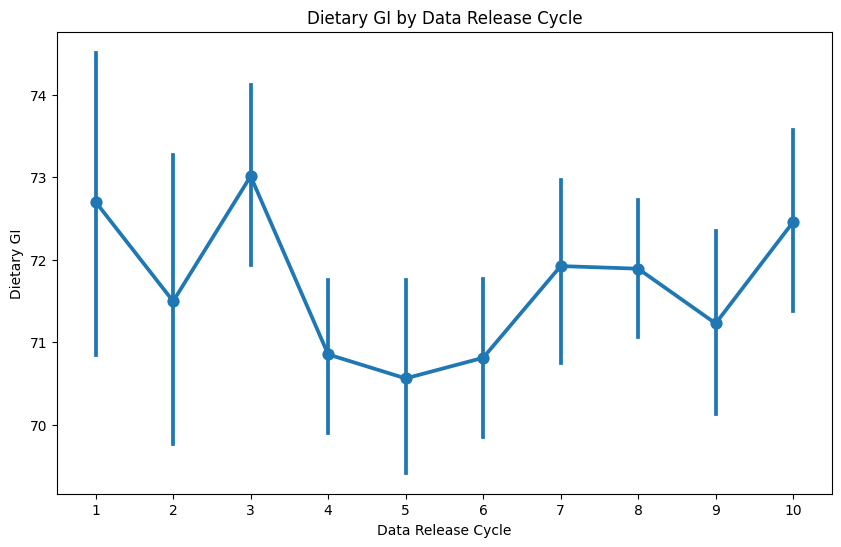

In [15]:
# prompt: create a plot showing means of df['Dietary GL'] aggregated by column Data release cycle

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.pointplot(x='Data release cycle', y='Dietary GL', data=summed_df)
plt.xlabel('Data Release Cycle')
plt.ylabel('Dietary GL')
plt.title('Dietary GL by Data Release Cycle')
plt.show()

plt.figure(figsize=(10, 6))
sns.pointplot(x='Data release cycle', y='Dietary GI', data=summed_df)
plt.xlabel('Data Release Cycle')
plt.ylabel('Dietary GI')
plt.title('Dietary GI by Data Release Cycle')
plt.show()


Check out the plots. Do you see any interesting trends? Hopefully not, we drew random variables for GI!

Before these values could be interpreted, some important things need to be done.

1. The Dietary GL variable should be "adjusted" for total energy intake according to the residual method.
2. We also need to exclude unreasonbale consumption levels.
3. We want to use the NHANES weights to correctly calculate means.

In [20]:
#now we need to energy adjust!
from sklearn.linear_model import LinearRegression
import pandas as pd

for var in ['Dietary GI','Dietary GL', 'Available Carbohydrate']:
    #index to avoid nan!

    idx_energy = summed_df['Energy (kcal)'].notna()
    idx = summed_df['Energy (kcal)'].notna() & summed_df[var].notna()

    # Separate the independent variable (X) and the dependent variable (Y)
    X, Y = summed_df['Energy (kcal)'][idx].to_numpy().reshape(-1, 1),summed_df[var][idx].to_numpy().reshape(-1, 1)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(X, Y)

    # Get the slope (m) and y-intercept (b)
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict Y values based on the regression line
    predicted_Y = model.predict(X)

    #Avoid missing or execssive consumption levels
    condition1 = summed_df['Energy (kcal)'] > 600
    condition2 = summed_df['Energy (kcal)'] < 5000

    baseline_df = summed_df[(condition1 & condition2)]

    mean_kcal = (baseline_df['Energy (kcal)'] * baseline_df['Dietary 20 Year Weight']).sum() / baseline_df['Dietary 20 Year Weight'].sum()
    print('Baseline Energy intake mean', mean_kcal)
    baseline = model.predict(np.array([mean_kcal]).reshape(-1,1))[0][0]
    print(var, baseline)
    # Add the new variable
    summed_df['Adjusted '+var] = pd.NA

    summed_df.loc[idx, 'Adjusted '+var] = (Y - predicted_Y) + baseline

summed_df


Baseline Energy intake mean 2104.5571064152923
Dietary GI 71.68018732656353
Baseline Energy intake mean 2104.5571064152923
Dietary GL 180.61259402525548
Baseline Energy intake mean 2104.5571064152923
Available Carbohydrate 250.96901930517456


,respondent sequence number,Dietary 20 Year Weight,Energy (kcal),Available Carbohydrate,Dietary GI,Dietary GL,Data release cycle,Adjusted Dietary GI,Adjusted Dietary GL,Adjusted Available Carbohydrate
0,1.0,1213.225733,1358.88,242.950,78.035439,189.58710,1,78.420249,251.992051,327.393807
1,73.0,1441.458533,1089.91,186.590,85.495739,159.52650,1,86.019352,244.441274,301.493171
2,93.0,11027.861243,1376.98,149.600,76.326872,114.18500,1,76.702341,175.075181,231.994082
3,962.0,6592.491222,1622.83,244.070,75.861843,185.15600,1,76.11044,225.471247,298.62293
4,1126.0,2010.452172,1467.16,153.510,70.024819,107.49510,1,70.353751,160.838209,225.691696
...,...,...,...,...,...,...,...,...,...,...
984,102352.0,2729.342226,2305.50,270.765,75.231085,202.66705,10,75.127387,185.850346,248.009329
985,102435.0,515.042577,3042.00,397.865,77.884912,309.83780,10,77.401141,231.384167,291.704779
986,102553.0,1074.611849,2470.00,256.925,70.009040,179.86050,10,69.820452,149.27696,215.540614
987,102823.0,5872.230549,1256.50,155.245,73.622712,114.94100,10,74.060355,185.914028,251.282775


This dataset could be used to calculate linear regressions. However, NHANES follows a complex sample design, requiring more involved error calculations. Details can be found here: https://wwwn.cdc.gov/nchs/nhanes/tutorials/varianceestimation.aspx .
Unfortunately, Python does not provide the right implementation to do this calculation (and our example dataset omits the necessary PSU information), but in R, Strata, or SAS this can be easily done.

One last quick check we can do is a correlation analysis. For this we can scatter two variables.

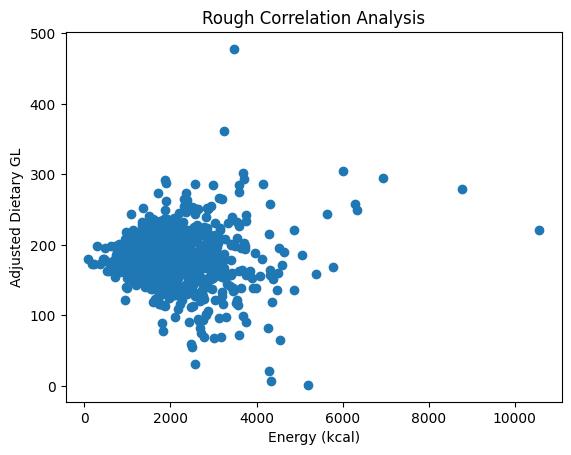

In [28]:
#define the variables of interest
x_var = 'Energy (kcal)'
y_var = 'Adjusted Dietary GL'

#plot
plt.scatter(summed_df[x_var], summed_df[y_var])
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title('Rough Correlation Analysis')
plt.show()

Which two variable do you expect to be highly correlated? Test a few combinations and check your intuition.